<a href="https://colab.research.google.com/github/finale22/NLP_study/blob/main/Text_Classification_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 데이터 로드 및 전처리

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# IMDB 원본 데이터 전처리
import os

imdb_dir = '/content/drive/MyDrive/DL/개인공부/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = [] # y
texts = []  # x

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)                 # 분류 카테고리 별 폴더 경로
    if label_type == 'neg':
        label = 0
    else:
        label = 1
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8') # 파일을 하나씩 읽기
            texts.append(f.read())                                   # texts 리스트에 추가
            f.close()
            labels.append(label)                                     # labels 리스트에 추가

In [5]:
print("text data")
for i in range(5):
    print(f"{texts[i]}: {labels[i]}\n")

text data
OK, so I just saw the movie, although it appeared last year... I thought that it was generally a decent movie, except for the storyline, which was stupid and horrible... First of all, we never get to know anything about the creatures, why they appeared, wtf are they doing in our world, and really, have they been on Earth before we were or did they just come from space? Secondly, the role of the butcher to maintain order is just so obviously created... Really, how large could the underground for a sub station could have been? There were only so many of those creatures, so I think instead of killing innocent people in vain, they could have just planted some tactical bombs, or maybe clear the are and a Nuke would have done the job. I know it sounds funny and it is, but I do not see the killing of people as being NECESSARY... Thirdly, Leon acts like Superman jumping on the train and fighting Vinnie Jones, who was way taller and bigger in stature. Then again, when he faces the con

# 2. 데이터 토큰화

In [9]:
# 텍스트 데이터 토큰화
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100                     # 토큰 개수 맞추기
training_samples = 200           # 훈련 샘플 개수
validation_samples = 10000       # 검증 샘플 개수
max_words = 10000                # 데이터셋에서 가장 빈도 높은 10000개의 단어만 사용

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(f"고유 토큰 개수: {len(word_index)}")

data = pad_sequences(sequences, maxlen=maxlen) # padding
labels = np.asarray(labels)
print(f"데이터 크기: {data.shape}")
print(f"레이블 크기: {labels.shape}")

indices = np.arange(data.shape[0]) # 데이터 분할 전 섞기 위한 작업
np.random.shuffle(indices)         # 섞기
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples + validation_samples]
y_val = labels[training_samples:training_samples + validation_samples]

고유 토큰 개수: 88582
데이터 크기: (25000, 100)
레이블 크기: (25000,)


# 3. GloVe 임베딩 전처리

In [12]:
glove_dir = '/content/drive/MyDrive/DL/개인공부'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(f"단어 벡터 개수: {len(embeddings_index)}")

단어 벡터 개수: 400000


In [13]:
# GloVe 단어 임베딩 행렬 준비
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector # 임베딩 인덱스에 없는 단어는 모두 0으로 처리

# 4. 모델 정의

In [14]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1320065 (5.04 MB)
Trainable params: 1320065 (5.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 5. 모델에 GloVe 임베딩 로드

In [15]:
# 사전 훈련된 단어 임베딩을 Embedding layer에 로드
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# 6. 모델 학습

In [16]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
hist = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 3s 120ms/step - loss: 1.1054 - acc: 0.5150 - val_loss: 0.7837 - val_acc: 0.5004
Epoch 2/10
7/7 [==============================] - 1s 110ms/step - loss: 0.6873 - acc: 0.5900 - val_loss: 1.1201 - val_acc: 0.5000
Epoch 3/10
7/7 [==============================] - 1s 97ms/step - loss: 0.5735 - acc: 0.6950 - val_loss: 0.7140 - val_acc: 0.5019
Epoch 4/10
7/7 [==============================] - 1s 94ms/step - loss: 0.3708 - acc: 0.8400 - val_loss: 0.7265 - val_acc: 0.5051
Epoch 5/10
7/7 [==============================] - 1s 95ms/step - loss: 0.3057 - acc: 0.8900 - val_loss: 0.7427 - val_acc: 0.5005
Epoch 6/10
7/7 [==============================] - 1s 111ms/step - loss: 0.3314 - acc: 0.8150 - val_loss: 0.7849 - val_acc: 0.5003
Epoch 7/10
7/7 [==============================] - 1s 97ms/step - loss: 0.1079 - acc: 0.9950 - val_loss: 0.8392 - val_acc: 0.5034
Epoch 8/10
7/7 [==============================] - 1s 110ms/step - loss: 0.0745 - acc: 1.0000 -

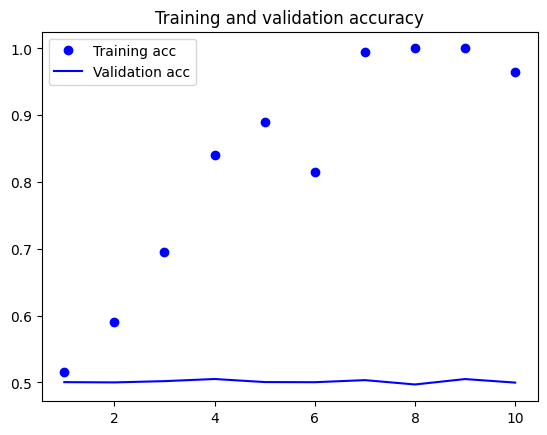

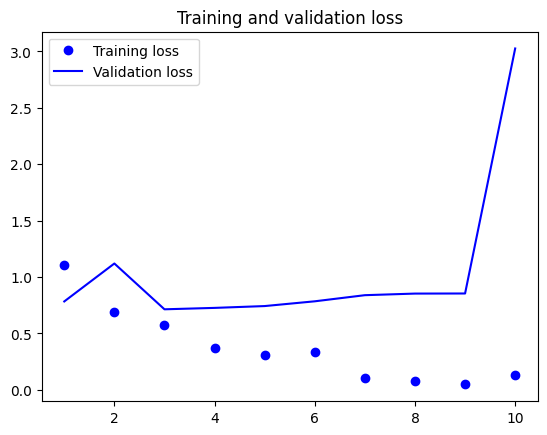

In [17]:
# 그래프
import matplotlib.pyplot as plt

history = hist.history
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 학습 데이터를 200개만 사용했으므로 Training Accuracy 그래프를 통해 과적합이 빠르게 시작된 것을 확인할 수 있고 Training Accuracy와 Validation Accuracy의 차이 또한 크다.

### loss 그래프도 Training loss는 과적합으로 인해 0에 수렴하고 있는 모습을 보이지만 Validation loss는 오히려 10번째 학습에서 값이 크게 튄 모습을 확인할 수 있다.

### 이진 분류 모델의 Validation Accuracy가 0.5라는 것은 사실상 답을 맞춘다기 보다 그냥 찍는 수준이고 따라서 현재의 모델은 형편없다고 할 수 있다. 하지만 학습 데이터 개수를 늘리고 Early Stopping을 사용하여 과적합을 방지한다면 성능이 좋아질 것으로 예상된다.

# 7. 사전 훈련된 단어 임베딩을 사용하지 않고 모델 학습

In [19]:
# 사전 훈련된 단어 임베딩을 사용하지 않고 같은 모델 학습하기
# 사전 훈련된 단어 임베딩을 사용하여 학습하는 것과 사용하지 않고 학습하는 것을 비교
from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

clear_session()
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1320065 (5.04 MB)
Trainable params: 1320065 (5.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
hist = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 3s 337ms/step - loss: 0.6925 - acc: 0.5250 - val_loss: 0.6998 - val_acc: 0.5020
Epoch 2/10
7/7 [==============================] - 2s 269ms/step - loss: 0.5800 - acc: 0.9400 - val_loss: 0.7029 - val_acc: 0.5018
Epoch 3/10
7/7 [==============================] - 1s 211ms/step - loss: 0.4420 - acc: 0.9750 - val_loss: 0.7129 - val_acc: 0.5001
Epoch 4/10
7/7 [==============================] - 1s 188ms/step - loss: 0.2849 - acc: 0.9900 - val_loss: 0.7077 - val_acc: 0.5013
Epoch 5/10
7/7 [==============================] - 2s 319ms/step - loss: 0.1634 - acc: 0.9950 - val_loss: 0.7073 - val_acc: 0.5048
Epoch 6/10
7/7 [==============================] - 2s 246ms/step - loss: 0.0961 - acc: 1.0000 - val_loss: 0.7419 - val_acc: 0.5028
Epoch 7/10
7/7 [==============================] - 1s 164ms/step - loss: 0.0575 - acc: 1.0000 - val_loss: 0.7351 - val_acc: 0.5019
Epoch 8/10
7/7 [==============================] - 1s 160ms/step - loss: 0.0366 - acc: 1.00

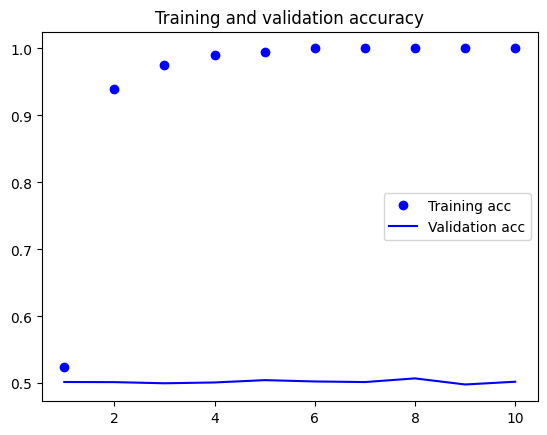

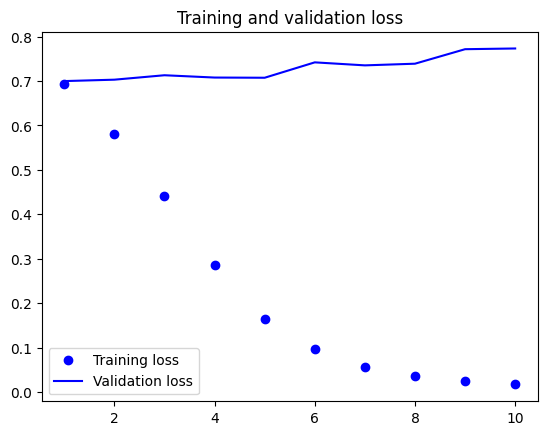

In [21]:
# 그래프
import matplotlib.pyplot as plt

history = hist.history
acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 2번째 학습부터 Training Accuracy가 1에 가까워지는 과적합 성향을 보인다. 그리고 Validation Accuracy는 0.5에 계속 머물러있다.

### Training loss는 우하향하고 있으나 Validation loss는 오히려 높아지고 있어 이 모델 또한 매우 좋지 않은 모델이라고 할 수 있다.

# 8. 모델 평가

In [22]:
# 테스트 데이터 전처리

train_dir = os.path.join(imdb_dir, 'test')

labels = [] # y
texts = []  # x

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)                 # 분류 카테고리 별 폴더 경로
    if label_type == 'neg':
        label = 0
    else:
        label = 1
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8') # 파일을 하나씩 읽기
            texts.append(f.read())                                   # texts 리스트에 추가
            f.close()
            labels.append(label)                                     # labels 리스트에 추가

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [23]:
# 사전 학습된 임베딩을 사용한 모델의 성능 평가
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.7753 - acc: 0.5047


[0.7753381133079529, 0.5046799778938293]

### 앞서 사전 학습된 임베딩을 사용한 모델의 Validation Accuracy에서도 확인할 수 있듯이 테스트 정확도는 0.5로 성능이 매우 좋지 않은 모델이다.

### 적은 수의 훈련 샘플로 작업하는 것은 어려운 일이다. 하지만 학습 데이터를 늘려본다면...